In [2]:
import strawberryfields as sf
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import cm

import seaborn as sns

In [722]:
def OneModeCoherentHO(Ns,t,nth,shots):
    """
    Function that performs sensing using a single coherent state and performing homodyne measurements
    
    Args:
    
        Ns (float) : Average number of photons in the #1 mode
        t,nth (float,float) : channel transmittivity and number of thermal photons for the thermal loss channel
        shots (integer) : number of repeated iid measurements to perform
    
    Returns:
    
        list, list (complex,complex): returns the complex signal <X>+i<P> of both modes
    
    
    
    """
    s1 = np.zeros(shots)

    alpha = np.sqrt(Ns/4)
    
    for i in range(shots):
        prog= sf.Program(1)
        
        with prog.context as q:
        
            sf.ops.Coherent(alpha) | q[0] # State preparation
            sf.ops.ThermalLossChannel(t,nth) | q[0] # Thermal loss channel mimicing target
     
            sf.ops.MeasureX | q[0] # Het. Msmnt of signal 1


        # Need to run twice because of bug in the bosonic backend in dealing with repeated HD measurements
    
        eng = sf.Engine("bosonic")
        results = eng.run(prog)
    
        #Collecting the samples
        samples = results.all_samples
    
        #Creating the measurement records
        s1[i] = samples[0][0]
    
    # Interation over number of shots is done, outputing the records
    
    return s1

def OneModeCoherentHD(Ns,t,nth,shots):
    """
    Function that performs sensing using a single coherent state and performing heterodyne measurements

    Args:
    
        Ns (float) : Average number of photons in the #1 mode
        t,nth (float,float) : channel transmittivity and number of thermal photons for the thermal loss channel
        shots (integer) : number of repeated iid measurements to perform
    
    Returns:
    
        list, list (complex,complex): returns the complex signal <X>+i<P> of both modes
    
    
    
    """
    s1 = (1+1j)*np.zeros(shots)

    alpha = np.sqrt(Ns/4)
    
    for i in range(shots):
        prog= sf.Program(1)
        
        with prog.context as q:
        
            sf.ops.Coherent(alpha) | q[0] # State preparation
            sf.ops.ThermalLossChannel(t,nth) | q[0] # Thermal loss channel mimicing target
     
            sf.ops.MeasureHD | q[0] # Het. Msmnt of signal 1


        # Need to run twice because of bug in the bosonic backend in dealing with repeated HD measurements
    
        eng = sf.Engine("bosonic")
        results = eng.run(prog)
        
    
        #Collecting the samples
        samples = results.all_samples
    
        #Creating the measurement records
        s1[i] = samples[0][0]
    
    # Interation over number of shots is done, outputing the records
    
    return s1


def TwoModeSqueezedHD(Ns,t,nth,shots):
    
    """
    Function that performs sensing using two-mode squeezing and performing heterodyne measurements
    
    Args:
    
        Ns (float) : Average number of photons in the #1 mode
        t,nth (float,float) : channel transmittivity and number of thermal photons for the thermal loss channel
        shots (integer) : number of repeated iid measurements to perform
    
    Returns:
    
        list, list (complex,complex): returns the complex signal <X>+i<P> of both modes
    
    
    
    """
    
    s1 = (1+1j)*np.zeros(shots)
    s2 = (1+1j)*np.zeros(shots)
    
    r = np.arcsinh(np.sqrt(Ns/2))
    
    for i in range(shots):
        prog= sf.Program(2)
        
        with prog.context as q:
        
            sf.ops.S2gate(r,0) | (q[0],q[1]) # State preparation
            sf.ops.ThermalLossChannel(t,nth) | q[0] # Thermal loss channel mimicing target
     
            sf.ops.MeasureHD | q[0] # Het. Msmnt of signal 1
            sf.ops.MeasureHD | q[1] # Het. Msmnt of signal 2

        # Need to run twice because of bug in the bosonic backend in dealing with repeated HD measurements
    
        eng = sf.Engine("bosonic")
        results = eng.run(prog)
        eng = sf.Engine("bosonic")
        results = eng.run(prog)
    
        #Collecting the samples
        samples = results.all_samples
    
        #Creating the measurement records
        s1[i] = samples[0][0]
        s2[i] = samples[1][0]
    
    # Interation over number of shots is done, outputing the records
    
    return s1,s2

def TwoModeThermalHD(Ns,t,nth,shots):
    
    """
    Function that performs sensing using two-mode thermal states that are classically correlated and performing heterodyne measurements
    
    Args:
    
        Ns (float) : Average number of photons in the #1 mode
        t,nth (float,float) : channel transmittivity and number of thermal photons for the thermal loss channel
        shots (integer) : number of repeated iid measurements to perform
    
    Returns:
    
        list, list (complex,complex): returns the complex signal <X>+i<P> of both modes
    
    
    
    """
    
    s1 = (1+1j)*np.zeros(shots)
    s2 = (1+1j)*np.zeros(shots)
    

    
    for i in range(shots):
        prog= sf.Program(2)
        
        with prog.context as q:
        
            sf.ops.Thermal(Ns) | q[0] # State preparation
            sf.ops.BSgate() | (q[0],q[1])
            
            sf.ops.ThermalLossChannel(t,nth) | q[0] # Thermal loss channel mimicing target
     
            sf.ops.MeasureHD | q[0] # Het. Msmnt of signal 1
            sf.ops.MeasureHD | q[1] # Het. Msmnt of signal 2

        # Need to run twice because of bug in the bosonic backend in dealing with repeated HD measurements
    
        eng = sf.Engine("bosonic")
        results = eng.run(prog)
        eng = sf.Engine("bosonic")
        results = eng.run(prog)
    
       
        
        #Collecting the samples
        samples = results.all_samples
    
        #Creating the measurement records
        s1[i] = samples[0][0]
        s2[i] = samples[1][0]
    
    # Interation over number of shots is done, outputing the records
    
    return s1,s2

def SNR(op0, op1):
    """ Function that evaluates the signal-to-noise ratio of a given operator depending 
    on the msmt statistics on a binary outcome repeated over N independant and inditically distributed measurements.
    
        We define SNR as
        SNR = N* |<op1> - <op0>|^2 / ((Var[op0]+ Var[op1])/2)
        
        <x> statistical average of operator x
        Var[x] denotes the variance of x
        N = len(x) : the number of samples in the measurement records
        
    Args:
    
        op0, op1 (complex array length N ) : array N elements with the expectation values over N iids of an operator op given the binary outcome 0 or 1
        
    
    Returns:
    
        float: SNR calculation from the above equation
        
        
        
    
    """
    result = len(op0)*np.abs(np.mean(op1) - np.mean(op0))**2/((np.var(op1)+np.var(op0))/2)
    
    return result


Ok so now, we need to have a binary hypothesis test:

Target absent : H = 0 s1 is completely lost and totally replaced by atmospheric noise. Channel transmittivity t =0

Target present : H =1 s1 is reflected with probability r = 1 - t, where t is the channel transmittivity



Overall setup configuration

In [723]:
#Transmit power parameters
Ns = 10

#Loss Channel parameters
nth=1000
t=0.0001

# Number of measurements
shots=10000

np.random.seed(42)

COHERENT STATE + HOMODYNE DETECTION

In [724]:
#Target Absent 
s10 = np.zeros(shots)

s10 = OneModeCoherentHO(Ns,0,nth,shots)
M0=s10

# Target Present
s11 = np.zeros(shots)
s11 = OneModeCoherentHO(Ns,t,nth/np.sqrt(1-t),shots)
M1=s11

SNR_CHO=SNR(M0,M1)

In [725]:
print(SNR_CHO)

0.8024701742978395


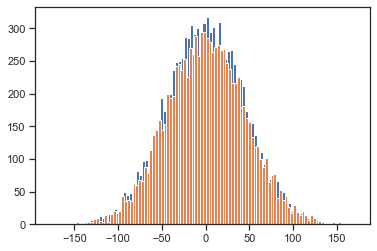

In [726]:
plt.hist(M0,bins=100);
plt.hist(M1,bins=100);
plt.show()

COHERENT STATE + HETERODYNE DETECTION

In [727]:
#Target Absent 
s10 = np.zeros(shots)
s10 = OneModeCoherentHD(Ns,0,nth,shots)

# Target Present
s11 = np.zeros(shots)
s11 = OneModeCoherentHD(Ns,t,nth/np.sqrt(1-t),shots)

M0=s10.real*s10.real + s10.imag*s10.imag
M1=s11.real*s11.real + s11.imag*s11.imag

SNR_CHD=SNR(M0,M1)

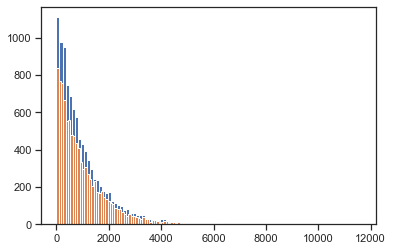

In [728]:
plt.hist(M0,bins=100);
plt.hist(M1,bins=100);
plt.show()

In [729]:
print(SNR_CHD)

0.3364100310419132


TWO-MODE THERMAL STATES (Classically correlated) + HETERODYNE

In [730]:
#Target Absent 
s10 = (1+1j)*np.zeros(shots)
s20 = (1+1j)*np.zeros(shots)

s10,s20 = TwoModeThermalHD(Ns,0,nth,shots)
M0=s10.real*s20.real + s10.imag*s20.imag

# Target Present
s11 = (1+1j)*np.zeros(shots)
s21 = (1+1j)*np.zeros(shots)

s11,s21 = TwoModeThermalHD(Ns,t,nth/np.sqrt(1-t),shots)

M1=s11.real*s21.real + s11.imag*s21.imag

SNR_2TH = SNR(M0,M1)

In [731]:
print(SNR_2TH)

4.6189223712277725


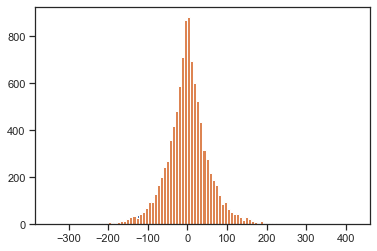

In [732]:
plt.hist(M0,bins=100);
plt.hist(M1,bins=100);
plt.show()

TWO-MODE SQUEEZED STATES + HETERODYNE

In [737]:
#Target Absent 
M0 = np.zeros(shots)
s10 = (1+1j)*np.zeros(shots)
s20 = (1+1j)*np.zeros(shots)

s10,s20 = TwoModeSqueezedHD(Ns,0,nth,shots)
M0=s10.real*s20.real - s10.imag*s20.imag

# Target Present
M1 = np.zeros(shots)
s11 = (1+1j)*np.zeros(shots)
s21 = (1+1j)*np.zeros(shots)


s11,s21 = TwoModeSqueezedHD(Ns,t,nth/np.sqrt(1-t),shots)
M1=s11.real*s21.real - s11.imag*s21.imag

SNR_2SQ = SNR(M0,M1)

In [738]:
print(SNR_2SQ)

0.3896304715272131


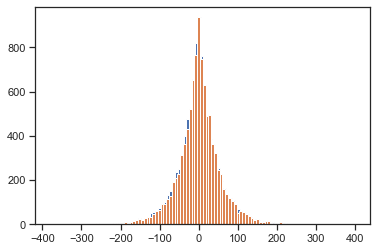

In [739]:
plt.hist(M0.real,bins=100);
plt.hist(M1.real,bins=100);
plt.show()

CHECKS

In [736]:
prog= sf.Program(6)

Ns=10

with prog.context as q:
    
    sf.ops.Thermal(Ns/2) | q[0] # State preparation
    sf.ops.Coherent(np.sqrt(Ns/4),0) | q[1]
    sf.ops.S2gate(np.arcsinh(np.sqrt(Ns/2)),0) | (q[2],q[3])
    sf.ops.Thermal(Ns) | q[4]
    sf.ops.BSgate() |(q[4],q[5])
    
eng = sf.Engine("gaussian")
result = eng.run(prog)
states=result.state

mu0,cov0 = states.reduced_gaussian([0])
mu1,cov1 = states.reduced_gaussian([1])
mu23,cov23 = states.reduced_gaussian([2,3])
mu45,cov45 = states.reduced_gaussian([4,5])

print(mu0,cov0)
print(mu1**2,cov1)
print(mu23,cov23)
print(mu45,cov45)

[0. 0.] [[11.  0.]
 [ 0. 11.]]
[10.  0.] [[1. 0.]
 [0. 1.]]
[0. 0. 0. 0.] [[ 11.          10.95445115   0.           0.        ]
 [ 10.95445115  11.           0.           0.        ]
 [  0.           0.          11.         -10.95445115]
 [  0.           0.         -10.95445115  11.        ]]
[0. 0. 0. 0.] [[11. 10.  0.  0.]
 [10. 11.  0.  0.]
 [ 0.  0. 11. 10.]
 [ 0.  0. 10. 11.]]
